In [1]:
import numpy
import urllib
import scipy.optimize
import random
from math import exp
from math import log

In [2]:
random.seed(0)

In [3]:
def parseData(fname):
    for l in urllib.urlopen(fname):
        yield eval(l)

In [4]:
print "Reading data..."
dataFile = open("winequality-white.csv")
header = dataFile.readline()
fields = ["constant"] + header.strip().replace('"','').split(';')
featureNames = fields[:-1]
labelName = fields[-1]
lines = [[1.0] + [float(x) for x in l.split(';')] for l in dataFile]
# random.shuffle(lines)
X = [l[:-1] for l in lines]
y = [l[-1] > 5 for l in lines]
print "done"

Reading data...
done


In [5]:
def inner(x,y):
    return sum([x[i]*y[i] for i in range(len(x))])

In [6]:
def sigmoid(x):
    return 1.0 / (1 + exp(-x))

### Logistic regression by gradient ascent

In [49]:
# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
    loglikelihood = 0.
    for i in range(len(X)):
        logit = inner(X[i], theta)
        loglikelihood -= log(1 + exp(-logit))
        if not y[i]:
            loglikelihood -= logit
    for k in range(len(theta)):
        loglikelihood -= lam * theta[k]*theta[k]
    # for debugging
    # print "ll =", loglikelihood
    return -loglikelihood

In [21]:
# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
    dl = [0]*len(theta)
    for i in range(len(X)):
        logit = inner(X[i], theta)
        for k in range(len(theta)):
            dl[k] += X[i][k] * (1 - sigmoid(logit))
            if not y[i]:
                dl[k] -= X[i][k]
    for k in range(len(theta)):
        dl[k] -= lam*2*theta[k]
    return numpy.array([-x for x in dl])

In [7]:
X_train = X[:int(len(X)/3)]
y_train = y[:int(len(y)/3)]
X_validate = X[int(len(X)/3):int(2*len(X)/3)]
y_validate = y[int(len(y)/3):int(2*len(y)/3)]
X_test = X[int(2*len(X)/3):]
y_test = y[int(2*len(X)/3):]

### Train

In [23]:
def train(lam):
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
    return theta

### Predict

In [24]:
def performance(theta):
    scores_train = [inner(theta,x) for x in X_train]
    scores_validate = [inner(theta,x) for x in X_validate]
    scores_test = [inner(theta,x) for x in X_test]

    predictions_train = [s > 0 for s in scores_train]
    predictions_validate = [s > 0 for s in scores_validate]
    predictions_test = [s > 0 for s in scores_test]

    correct_train = [(a==b) for (a,b) in zip(predictions_train,y_train)]
    correct_validate = [(a==b) for (a,b) in zip(predictions_validate,y_validate)]
    correct_test = [(a==b) for (a,b) in zip(predictions_test,y_test)]

    acc_train = sum(correct_train) * 1.0 / len(correct_train)
    acc_validate = sum(correct_validate) * 1.0 / len(correct_validate)
    acc_test = sum(correct_test) * 1.0 / len(correct_test)
    return acc_train, acc_validate, acc_test


### 1. Validation pipeline
Randomly re-shuffle the data. random.shuffle(lines)

In [16]:
for lam in [0, 0.01, 1.0, 100.0]:
    theta = train(lam)
    acc_train, acc_validate, acc_test = performance(theta)
    print("lambda = " + str(lam) + ";\ttrain=" + str(acc_train) + "; validate=" + str(acc_validate) + "; test=" + str(acc_test))

lambda = 0;	train=0.748774509804; validate=0.757501530925; test=0.738518064911
lambda = 0.01;	train=0.748774509804; validate=0.756889161053; test=0.738518064911
lambda = 1.0;	train=0.729166666667; validate=0.753827311696; test=0.72933251684
lambda = 100.0;	train=0.66237745098; validate=0.681567666871; test=0.680342927128


### 2. Evaluate classifier
$\lambda = 0.01$. Use only the test set from the original 1/3,1/3,1/3 split for this question

In [57]:
def test_performance(lam):
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_test, y_test, lam))
    scores_test = [inner(theta,x) for x in X_test]
    predictions_test = [s > 0 for s in scores_test]
    TP,TN,FP,FN = [0 for j in range(4)]
    for i in range(len(y_test)):
        label = y_test[i]
        pred = predictions_test[i]
        if ((label == 1) and (pred == 1)):
            TP += 1
        if ((label == 0) and (pred == 0)):
            TN += 1
        if ((label == 0) and (pred == 1)):
            FP += 1
        if ((label == 1) and (pred == 0)):
            FN += 1
    return TP, TN, FP, FN, scores_test

In [58]:
tp, tn, fp, fn, scores_test = test_performance(0.01)
TPR = 1.0 * tp / (tp + fn) # True positive rate
TNR = 1.0 * tn / (tn + fp) # True negative rate
BER = 1.0 - 0.5 * (TPR + TNR)
print ("#True Positive = " + str(tp) + ";#True Negative = " + str(tn) + "; #False Positive = " + str(fp) + "; #False Negative = " + str(fn))
print ("Balanced Error Rate of the classifier = " + str(BER))

#True Positive = 1075;#True Negative = 258; #False Positive = 208; #False Negative = 92
Balanced Error Rate of the classifier = 0.262593275005


### 3. Rank prediction
By sorting the predictions by condence, compute the
precision and the recall when returning the top 10, 500, and 1000 predictions

In [59]:
confidence_test =  [(s, y) for (s,y) in zip(scores_test,y_test)]
sorted_y = [y for (s,y) in sorted(confidence_test,reverse=True)]
relevant = [y > 0 for y in sorted_y]

def calc_precision(num):
    retreived = [y > 0 for y in sorted_y[:num]]
    retreived = [y > 0 for y in sorted_y[:num]]
    precision = 1.0 * sum(retreived) / num
    return precision

def calc_recall(num):
    retreived = [y > 0 for y in sorted_y[:num]]
    retreived = [y > 0 for y in sorted_y[:num]]
    recall = 1.0 * sum(retreived)  / len(relevant)
    return recall

In [60]:
for i in [10,500,1000]:
    precision = calc_precision(i)
    recall = calc_recall(i)
    print ("precision_" + str(i) +" = " +str(precision)+"; "),
    print ("recall_" + str(i) +" = " +str(recall))

precision_10 = 0.9;  recall_10 = 0.00551132884262
precision_500 = 0.946;  recall_500 = 0.289650949173
precision_1000 = 0.898;  recall_1000 = 0.549908144519


### 4. Plot precision versus recall

In [19]:
%matplotlib inline 
import matplotlib.pyplot as plt

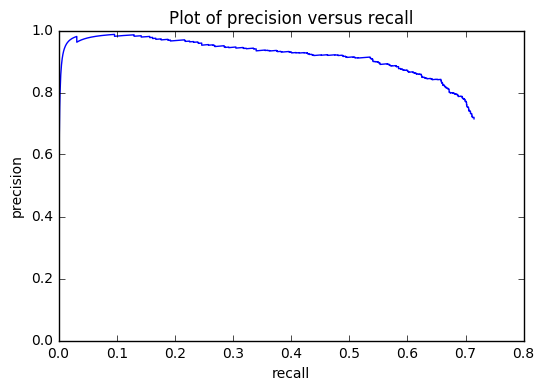

In [30]:
p = [calc_precision(i) for i in range(1,len(y_test))]
r = [calc_recall(i) for i in range(1,len(y_test))]
plt.plot(r, p)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('Plot of precision versus recall')

## Dimensionality reduction
### 5. reconstruction error

In [8]:
X_train = [x[1:] for x in X[:int(len(X)/3)]]
X_mean = numpy.mean(X_train, axis=0)
re = 0. # reconstruction error
for i in range(len(X_train)):
    re += sum(numpy.square(numpy.subtract(X_train[i], X_mean)))
print "reconstruction error =", re

reconstruction error = 3675818.61688


### 6. Find the PCA components

In [16]:
import urllib
import scipy.optimize
from sklearn.decomposition import PCA
from collections import defaultdict

In [10]:
### PCA on beer reviews ###
pca = PCA(n_components=11)
pca.fit(X_train)
pca_error = pca.explained_variance_
print pca.components_

[[ -3.23636346e-04   1.42201752e-04   3.17030713e-04   5.36390435e-02
    9.30284526e-05   2.54030965e-01   9.65655009e-01   3.19990241e-05
   -2.95831396e-04   3.84043646e-04  -1.00526693e-02]
 [ -7.57985623e-03  -1.66366340e-03   1.04742899e-03   5.21677266e-02
    4.49425600e-05   9.65020304e-01  -2.56793964e-01   7.90089050e-06
    5.24900596e-04  -1.09699394e-03  -2.89827657e-03]
 [  1.82124420e-02   2.54680710e-03   3.31838657e-03   9.93221259e-01
   -1.51888372e-04  -6.42297821e-02  -3.91682592e-02   4.30929482e-04
   -6.93199060e-03  -2.85216045e-03  -8.62920933e-02]
 [  1.56811999e-01   3.28220652e-03   1.66866136e-02   8.28549640e-02
   -6.91822288e-03   1.13029682e-03   5.39110108e-03  -9.49080503e-04
    2.68027305e-03   1.30498102e-03   9.83955205e-01]
 [  9.81360642e-01  -1.45890108e-02   5.92643662e-02  -3.17546064e-02
    5.07483182e-04   8.43759364e-03  -1.77578042e-03   6.03725221e-04
   -9.05011239e-02  -9.35630845e-03  -1.54417839e-01]
 [  7.76578401e-02  -2.3766588

### 7. compress the data using just four PCA dimensions.

In [11]:
pca = PCA(n_components=4)
pca.fit(X_train)
X_transform = pca.transform(X_train)
X_reconstruction = pca.inverse_transform(X_transform)
re = 0. # reconstruction error
for i in range(len(X_train)):
    re += sum(numpy.square(numpy.subtract(X_train[i], X_reconstruction[i])))
print "reconstruction error =", re

reconstruction error = 1345.4755741


### 8. predict the quality score, using increasingly many PCA dimensions

In [12]:
def compute_MSE(a,X,y):
    error = 0.
    length = len(y)
    for i in range(length):
        error += (y[i] - numpy.dot(a,X[i])) ** 2
    return error / length

In [13]:
MSE_train = []
MSE_test = []
for d in range(1,12):
    pca = PCA(n_components=d)
    pca.fit(X_train)
    X_reconstruction = pca.transform(X_train)
    X_regression = [[1.0] + x for x in X_reconstruction]
    theta,residuals,rank,s = numpy.linalg.lstsq(X_regression, y_train)
    MSE_train.append(compute_MSE(theta,X_regression,y_train))
    
for d in range(1,12):
    pca = PCA(n_components=d)
    pca.fit(X_test)
    X_reconstruction = pca.transform(X_test)
    X_regression = [[1.0,] + x for x in X_reconstruction]
    theta,residuals,rank,s = numpy.linalg.lstsq(X_regression, y_test)
    MSE_test.append(compute_MSE(theta,X_regression,y_test))

In [14]:
print MSE_train
print MSE_test

[0.65581949875389367, 0.64676394620000566, 0.64031648680891573, 0.32579235577701915, 0.28996472114725952, 0.18893841380392501, 0.18867195247498933, 0.18756587969688093, 0.18132780683413804, 0.17961957974079035, 0.17906571809404909]
[0.7066354371722573, 0.68940993018977337, 0.66318555134306889, 0.31835080554475659, 0.23842120584777782, 0.15987339529583075, 0.15943062569331454, 0.15909834017343297, 0.15882513229280101, 0.14602793790223562, 0.14351399240234333]


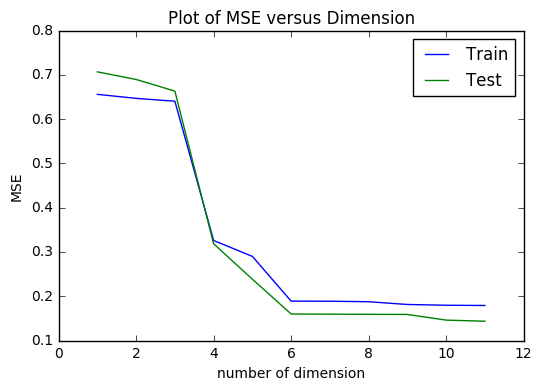

In [20]:
plt.plot(range(1,12), MSE_train)
plt.plot(range(1,12), MSE_test)
plt.legend(['Train','Test'])
plt.ylabel('MSE')
plt.xlabel('number of dimension')
plt.title('Plot of MSE versus Dimension')